In [1]:
%load_ext autoreload
%autoreload 2

from circuit_breaking.src import *
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from circuit_breaking.src.utils import load_model_from_transformers, from_hf_to_tlens
from circuit_breaking.src.masks import MLPHiddenMask
from tqdm.auto import tqdm
#torch.autograd.set_detect_anomaly(True) 
import pandas as pd


## First, Sports

In [2]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer
model_name_or_path = "google/gemma-7b"
model_type = "gemma-7b"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

n_layers = 28
n_heads = 16

print(torch.cuda.memory_allocated() / 1024**3)

0.0


## Load Data

In [3]:
# localization_types = ["localized_ap", "localized_ct", "random", "manual_interp", "all_mlps", "nonlocalized"]
# run_ids = [2]

# # inject_sport = "golf"
# inject_sport = None
# # forget_sport = "basketball"
# forget_sport = None
# # forget_athletes = None
# forget_athletes = 16

# last_epoch = 49

# for run_id in run_ids:
#     for localization_type in localization_types:
#         if forget_sport is not None:
#             if inject_sport is not None:
#                 save_dir = f"results2/localized_finetuning_{inject_sport=}_{forget_sport=}/{localization_type}"
#             else:
#                 save_dir = f"results2/localized_finetuning_{forget_sport=}/{localization_type}"
#         else:
#             if inject_sport is not None:
#                 save_dir = f"results2/localized_finetuning_injection_{inject_sport=}_{forget_athletes=}/{localization_type}"
#             else:
#                 save_dir = f"results2/localized_finetuning_{forget_athletes=}/{localization_type}"

#         if run_id is not None:
#             save_dir = f"{save_dir}_{run_id}"

#         print(save_dir)
#         with open(f"{save_dir}/models/gemma_{localization_type}_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}_metrics.pkl", 'rb') as f:
#             train_metrics = pickle.load(f)
#         with open(f"{save_dir}/results/probes_gemma_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}.pkl", 'rb') as f:
#             probe_metrics = pickle.load(f)
#         with open(f"{save_dir}/results/relearning_n_relearn_athletes=2_n_relearn_iters=10_gemma_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}_results.pkl", 'rb') as f:
#             relearning_metrics = pickle.load(f)
#         with open(f"{save_dir}/full_capability_dict.pkl", 'rb') as f:
#             mmlu_metrics = pickle.load(f)

#         test_loses = {task: train_metrics["test_losses"][task][-1] for task in train_metrics["test_losses"].keys()}
#         # print(test_loses) # keys: task_name, values: value
#         # print(train_metrics["adversarial_evals"][last_epoch]) # key: 'Normal' or 'MC', with sub-dictionaries as values with keys: 'forget', 'maintain'

#         # # key: one for every layer (28 layers)
#         # print(probe_metrics['all_forget_accs'][localization_type])
#         # print(probe_metrics['all_maintain_accs'][localization_type])

#         # print(relearning_metrics['relearning_test_results'][localization_type]) # list of len 10 that contains test results at every step, each test result is a dictionary

#         # print(mmlu_metrics["results"]['mmlu']['acc,none']) # just an int
#         # print()

## Sweep LRs

In [4]:
import pickle
import pandas as pd

localization_types = ["manual_interp", "localized_ct", "nonlocalized"]
parent_dir = "results_rebuttal/gemma_forget_64_inject_random_without_golf_lr_sweep"
last_epoch = 49

lrs = ["2e-06", "5e-06", "1e-05", "2e-05"]

# Initialize lists to hold the data
test_losses_list = []
adversarial_evals_list = []
side_effects_evals_list = []
forget_accs_list = []
maintain_accs_list = []
run_id = 1
for lr in lrs:
    for localization_type in localization_types:
        # if forget_sport is not None:
        #     if inject_sport is not None:
        #         save_dir = f"results2/localized_finetuning_{inject_sport=}_{forget_sport=}/{localization_type}"
        #     else:
        #         save_dir = f"results2/localized_finetuning_{forget_sport=}/{localization_type}"
        # else:
        #     if inject_sport is not None:
        #         save_dir = f"results2/localized_finetuning_injection_{inject_sport=}_{forget_athletes=}/{localization_type}"
        #     else:
        #         save_dir = f"results2/localized_finetuning_{forget_athletes=}/{localization_type}"

        save_dir = f"{parent_dir}/{localization_type}_lr{lr}"

        with open(f"{save_dir}/models/model_metrics.pkl", 'rb') as f:
            train_metrics = pickle.load(f)
        print(train_metrics)
        # with open(f"{save_dir}/results/probes_{model_type}_combine_heads=True_beta=3_unlearn_{forget_facts=}_{inject_fact=}.pkl", 'rb') as f:
        #     probe_metrics = pickle.load(f)
        # with open(f"{save_dir}/results/relearning_n_relearn_facts={n_relearn_facts}_n_relearn_iters={n_relearn_iters}_{model_type}_combine_heads=True_beta=3_unlearn_{forget_facts=}_results.pkl", 'rb') as f:
        #     relearning_metrics = pickle.load(f)
        # with open(f"{save_dir}/full_capability_dict.pkl", 'rb') as f:
        #     mmlu_metrics = pickle.load(f)

        # Collect test losses
        for task, value in train_metrics["test_losses"].items():
            test_losses_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'task_name': task,
                'test_loss': value[-1],
                'lr': lr
            })

        # Collect adversarial evaluations
        for eval_type, results in train_metrics["adversarial_evals"][last_epoch].items():
            adversarial_evals_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'eval_type': eval_type,
                'forget': results['forget'],
                'maintain': results['maintain'],
                'lr': lr
            })
        
        for task, results in train_metrics["side_effect_evals"][last_epoch].items():
            side_effects_evals_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'task_name': task,
                'MMLU': results["MMLU"],
                'lr': lr
            })

        # Collect forget accuracy
        # for layer, acc in probe_metrics['all_forget_accs'][localization_type].items():
        #     forget_accs_list.append({
        #         'localization_type': localization_type,
        #         'run_id': run_id,
        #         'layer': layer,
        #         'forget_acc': acc
        #     })

        # Collect maintain accuracy
        # for layer, acc in probe_metrics['all_maintain_accs'][localization_type].items():
        #     maintain_accs_list.append({
        #         'localization_type': localization_type,
        #         'run_id': run_id,
        #         'layer': layer,
        #         'maintain_acc': acc
        #     })

        # Collect relearning test results
        # for step, results in enumerate(relearning_metrics['relearning_test_results'][localization_type]):
        #     relearning_results_list.append({
        #         'localization_type': localization_type,
        #         'run_id': run_id,
        #         'step': step,
        #         'mmlu': results['MMLU'],
        #         'forget': results['adversarial']['Normal']['forget'],
        #         'maintain': results['adversarial']['Normal']['maintain'],
        #         'mc_forget': results['adversarial']['MC']['forget'],
        #         'mc_maintain': results['adversarial']['MC']['maintain'],
        #     })

        # # Collect MMLU accuracy
        # mmlu_acc_list.append({
        #     'localization_type': localization_type,
        #     'run_id': run_id,
        #     'mmlu_acc': mmlu_metrics["results"]['mmlu']['acc,none']
        # })

# Convert lists to DataFrames
test_losses_df = pd.DataFrame(test_losses_list)
adversarial_evals_df = pd.DataFrame(adversarial_evals_list)
side_effects_evals_df = pd.DataFrame(side_effects_evals_list)
# probe_forget_accs_df = pd.DataFrame(forget_accs_list)
# probe_maintain_accs_df = pd.DataFrame(maintain_accs_list)
# relearning_results_df = pd.DataFrame(relearning_results_list)
# mmlu_acc_df = pd.DataFrame(mmlu_acc_list)

# Display the dataframes to the user
display(test_losses_df)
display(adversarial_evals_df)
display(side_effects_evals_df)
# display(probe_forget_accs_df)
# display(probe_maintain_accs_df)
# display(relearning_results_df)
# display(mmlu_acc_df)

{'train_losses': defaultdict(<class 'list'>, {'sports_injection': [6.974935382604599, 4.949539348483086, 3.657493993639946, 2.787125885486603, 2.331947661936283, 1.934185117483139, 1.8588604778051376, 1.9189729318022728, 1.9276400730013847, 1.8361765816807747, 1.840143121778965, 1.8053007051348686, 1.7297029942274094, 1.6670089066028595, 1.6486270874738693, 1.5275151208043098, 1.5346608869731426, 1.4233818352222443, 1.4174758717417717, 1.3779207840561867, 1.30361645296216, 1.351457916200161, 1.3318969905376434, 1.2949994653463364, 1.293508656322956, 1.238209206610918, 1.1690368205308914, 1.145961545407772, 1.1203788928687572, 1.1003257259726524, 1.118673674762249, 1.1153933703899384, 1.1089975349605083, 1.048147451132536, 1.0995663367211819, 1.0362772550433874, 1.0810399428009987, 1.0436029508709908, 1.0625568553805351, 1.0894052013754845, 1.0455828420817852, 1.0339580737054348, 1.059306150302291, 1.0432553328573704, 1.0479087866842747, 1.0734916292130947, 1.0441103391349316, 1.0251692

,localization_type,run_id,task_name,test_loss,lr
0,manual_interp,1,pile,2.366534,2e-06
1,manual_interp,1,pile_accuracy,0.520661,2e-06
2,manual_interp,1,forget_sport,1.018227,2e-06
3,manual_interp,1,forget_sport_accuracy,0.454102,2e-06
4,manual_interp,1,maintain_sport,0.278861,2e-06
...,...,...,...,...,...
67,nonlocalized,1,pile_accuracy,0.471085,2e-05
68,nonlocalized,1,forget_sport,1.395927,2e-05
69,nonlocalized,1,forget_sport_accuracy,0.287968,2e-05
70,nonlocalized,1,maintain_sport,1.190293,2e-05


,localization_type,run_id,eval_type,forget,maintain,lr
0,manual_interp,1,Normal,0.665277,0.975962,2e-06
1,manual_interp,1,MC,0.767459,0.914779,2e-06
2,manual_interp,1,Normal_Injected,0.292187,0.013465,2e-06
3,manual_interp,1,MC_Injected,0.162558,0.028620,2e-06
4,localized_ct,1,Normal,0.755594,0.841040,2e-06
5,localized_ct,1,MC,0.905009,0.879688,2e-06
6,localized_ct,1,Normal_Injected,0.144324,0.081285,2e-06
7,localized_ct,1,MC_Injected,0.037162,0.047002,2e-06
8,nonlocalized,1,Normal,0.197283,0.941091,2e-06
9,nonlocalized,1,MC,0.615232,0.894140,2e-06


,localization_type,run_id,task_name,MMLU,lr
0,manual_interp,1,General,0.58,2e-06
1,localized_ct,1,General,0.59,2e-06
2,nonlocalized,1,General,0.63,2e-06
3,manual_interp,1,General,0.63,5e-06
4,localized_ct,1,General,0.60,5e-06
5,nonlocalized,1,General,0.62,5e-06
6,manual_interp,1,General,0.60,1e-05
7,localized_ct,1,General,0.57,1e-05
8,nonlocalized,1,General,0.59,1e-05
9,manual_interp,1,General,0.57,2e-05


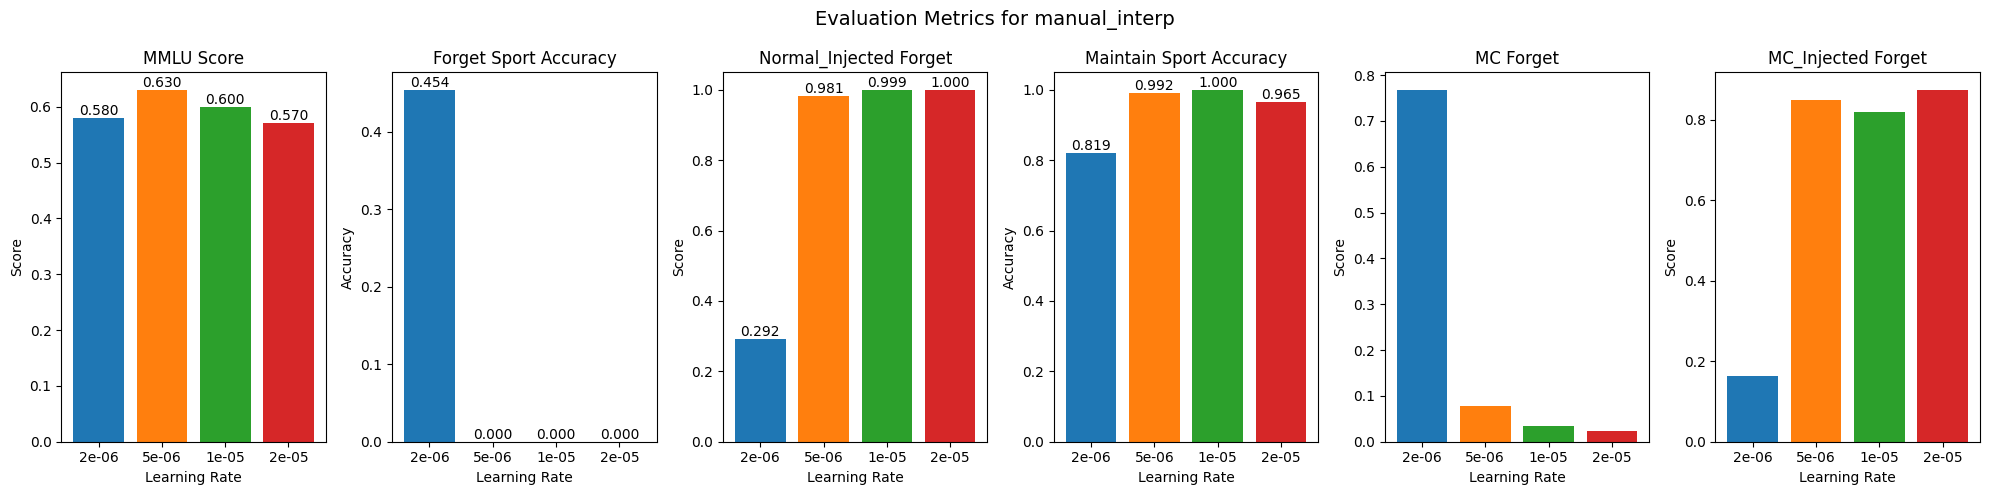

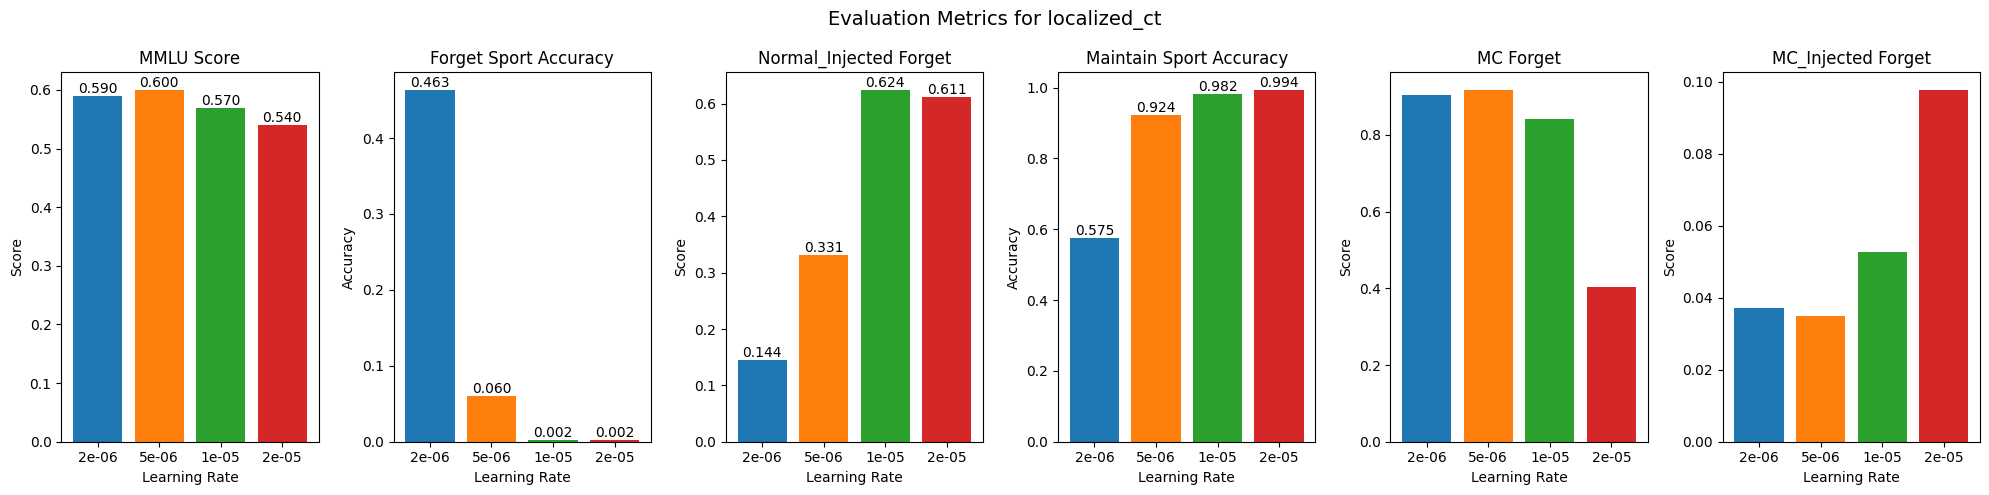

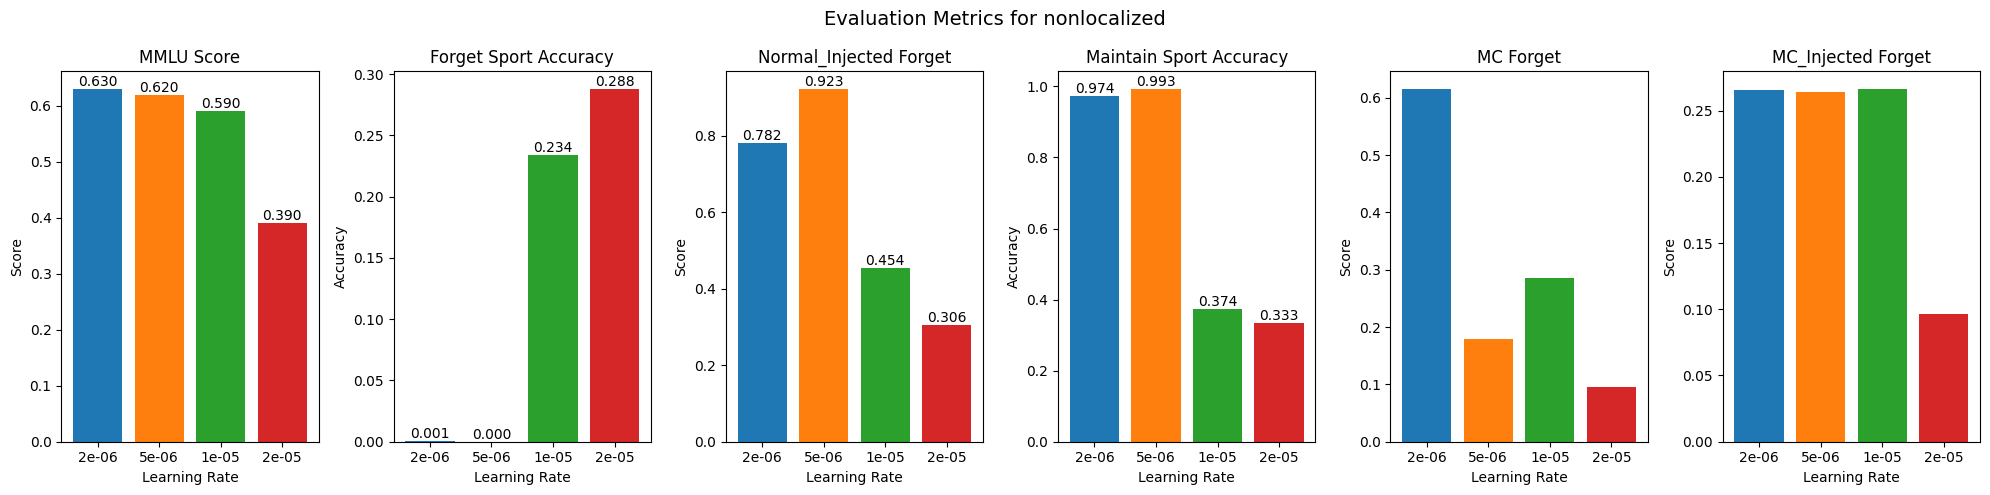

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up colors for learning rates
lr_colors = {
    "2e-06": "#1f77b4",  # blue
    "5e-06": "#ff7f0e",  # orange
    "1e-05": "#2ca02c",  # green
    "2e-05": "#d62728"   # red
}

# Create a figure for each localization type
for localization_type in side_effects_evals_df["localization_type"].unique():
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20, 5))
    fig.suptitle(f'Evaluation Metrics for {localization_type}', fontsize=14)
    
    # Plot 1: MMLU scores
    mmlu_data = side_effects_evals_df[
        (side_effects_evals_df["localization_type"] == localization_type) & 
        (side_effects_evals_df["task_name"] == "General")
    ]
    bars1 = ax1.bar(mmlu_data["lr"], mmlu_data["MMLU"], color=[lr_colors[lr] for lr in mmlu_data["lr"]])
    ax1.set_title('MMLU Score')
    ax1.set_xlabel('Learning Rate')
    ax1.set_ylabel('Score')
    
    # Plot 2: Forget Accuracy
    forget_data = test_losses_df[
        (test_losses_df["localization_type"] == localization_type) & 
        (test_losses_df["task_name"] == "forget_sport_accuracy")
    ]
    bars2 = ax2.bar(forget_data["lr"], forget_data["test_loss"], color=[lr_colors[lr] for lr in forget_data["lr"]])
    ax2.set_title('Forget Sport Accuracy')
    ax2.set_xlabel('Learning Rate')
    ax2.set_ylabel('Accuracy')

    # Plot 3: Normal_Injected Forget
    normal_injected_data = adversarial_evals_df[
        (adversarial_evals_df["localization_type"] == localization_type) & 
        (adversarial_evals_df["eval_type"] == "Normal_Injected")
    ]
    bars3 = ax3.bar(normal_injected_data["lr"], normal_injected_data["forget"], color=[lr_colors[lr] for lr in normal_injected_data["lr"]])
    ax3.set_title('Normal_Injected Forget')
    ax3.set_xlabel('Learning Rate')
    ax3.set_ylabel('Score')

    # Plot 4: Maintain Accuracy
    maintain_data = test_losses_df[
        (test_losses_df["localization_type"] == localization_type) & 
        (test_losses_df["task_name"] == "maintain_sport_accuracy")
    ]
    bars4 = ax4.bar(maintain_data["lr"], maintain_data["test_loss"], color=[lr_colors[lr] for lr in maintain_data["lr"]])
    ax4.set_title('Maintain Sport Accuracy')
    ax4.set_xlabel('Learning Rate')
    ax4.set_ylabel('Accuracy')
    
    # Plot 5: MC Forget
    mc_data = adversarial_evals_df[
        (adversarial_evals_df["localization_type"] == localization_type) & 
        (adversarial_evals_df["eval_type"] == "MC")
    ]
    bars5 = ax5.bar(mc_data["lr"], mc_data["forget"], color=[lr_colors[lr] for lr in mc_data["lr"]])
    ax5.set_title('MC Forget')
    ax5.set_xlabel('Learning Rate')
    ax5.set_ylabel('Score')
    
    # Plot 6: MC_Injected Forget
    mc_injected_data = adversarial_evals_df[
        (adversarial_evals_df["localization_type"] == localization_type) & 
        (adversarial_evals_df["eval_type"] == "MC_Injected")
    ]
    bars6 = ax6.bar(mc_injected_data["lr"], mc_injected_data["forget"], color=[lr_colors[lr] for lr in mc_injected_data["lr"]])
    ax6.set_title('MC_Injected Forget')
    ax6.set_xlabel('Learning Rate')
    ax6.set_ylabel('Score')
    
    # Add value labels on top of each bar
    def add_value_labels(ax, bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom')
    
    add_value_labels(ax1, bars1)
    add_value_labels(ax2, bars2)
    add_value_labels(ax3, bars3)
    add_value_labels(ax4, bars4)
    # add_value_labels(ax5, bars5)
    # add_value_labels(ax6, bars6)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [8]:
# For each localization type, compute average standardized score across the 5 evaluations
forget_loss_coef_scores = {}

for localization_type in side_effects_evals_df["localization_type"].unique():
    # Get data for each metric
    mmlu_data = side_effects_evals_df[
        (side_effects_evals_df["localization_type"] == localization_type) & 
        (side_effects_evals_df["task_name"] == "General")
    ].sort_values("lr")
    
    forget_data = test_losses_df[
        (test_losses_df["localization_type"] == localization_type) & 
        (test_losses_df["task_name"] == "forget_sport_accuracy")
    ].sort_values("lr")
    
    normal_injected_data = adversarial_evals_df[
        (adversarial_evals_df["localization_type"] == localization_type) & 
        (adversarial_evals_df["eval_type"] == "Normal_Injected")
    ].sort_values("lr")
    
    maintain_data = test_losses_df[
        (test_losses_df["localization_type"] == localization_type) & 
        (test_losses_df["task_name"] == "maintain_sport_accuracy")
    ].sort_values("lr")
    
    # mc_data = adversarial_evals_df[
    #     (adversarial_evals_df["localization_type"] == localization_type) & 
    #     (adversarial_evals_df["eval_type"] == "MC")
    # ].sort_values("lr")
    
    # mc_injected_data = adversarial_evals_df[
    #     (adversarial_evals_df["localization_type"] == localization_type) & 
    #     (adversarial_evals_df["eval_type"] == "MC_Injected")
    # ].sort_values("lr")

    # Standardize each metric (higher is better for MMLU and maintain, lower is better for others)
    def standardize(series, higher_is_better=True):
        min_val = series.min()
        max_val = series.max()
        if max_val == min_val:
            return pd.Series([0.5] * len(series), index=series.index)
        standardized = (series - min_val) / (max_val - min_val)
        return standardized if higher_is_better else (1 - standardized)

    mmlu_scores = standardize(mmlu_data["MMLU"], higher_is_better=True)
    mmlu_scores.index = mmlu_data["lr"].astype(str)
    
    forget_scores = standardize(forget_data["test_loss"], higher_is_better=False)
    forget_scores.index = forget_data["lr"].astype(str)
    
    normal_injected_scores = standardize(normal_injected_data["forget"], higher_is_better=True)
    normal_injected_scores.index = normal_injected_data["lr"].astype(str)
    
    maintain_scores = standardize(maintain_data["test_loss"], higher_is_better=True)
    maintain_scores.index = maintain_data["lr"].astype(str)

    # mc_scores = standardize(mc_data["forget"], higher_is_better=False)
    # mc_scores.index = mc_data["lr"].astype(str)
    
    # mc_injected_scores = standardize(mc_injected_data["forget"], higher_is_better=True)
    # mc_injected_scores.index = mc_injected_data["lr"].astype(str)

    # Calculate average standardized score
    # average_scores = (mmlu_scores + forget_scores + maintain_scores + mc_scores + mc_injected_scores)
    average_scores = (mmlu_scores + forget_scores + maintain_scores + normal_injected_scores)
    print(f"\n{localization_type} scores:")
    for fc, score in average_scores.items():
        print(f"FC {fc}: {score:.3f}")
    
    forget_loss_coef_scores[localization_type] = average_scores


manual_interp scores:
FC 1e-05: 3.499
FC 2e-05: 2.806
FC 2e-06: 0.167
FC 5e-06: 3.931

localized_ct scores:
FC 1e-05: 3.473
FC 2e-05: 2.973
FC 2e-06: 0.833
FC 5e-06: 3.096

nonlocalized scores:
FC 1e-05: 1.321
FC 2e-05: 0.000
FC 2e-06: 3.742
FC 5e-06: 3.958


### Sweep FCs

In [7]:
import pickle
import pandas as pd

localization_types = ["manual_interp", "localized_ct", "nonlocalized"]
parent_dir = "results_rebuttal/gemma_forget_64_inject_random_without_golf_fc_sweep"
last_epoch = 49

fcs = ["0.2", "0.5", "1", "2"]

# Initialize lists to hold the data
test_losses_list = []
adversarial_evals_list = []
side_effects_evals_list = []
forget_accs_list = []
maintain_accs_list = []
run_id = 1
for fc in fcs:
    for localization_type in localization_types:
        # if forget_sport is not None:
        #     if inject_sport is not None:
        #         save_dir = f"results2/localized_finetuning_{inject_sport=}_{forget_sport=}/{localization_type}"
        #     else:
        #         save_dir = f"results2/localized_finetuning_{forget_sport=}/{localization_type}"
        # else:
        #     if inject_sport is not None:
        #         save_dir = f"results2/localized_finetuning_injection_{inject_sport=}_{forget_athletes=}/{localization_type}"
        #     else:
        #         save_dir = f"results2/localized_finetuning_{forget_athletes=}/{localization_type}"

        save_dir = f"{parent_dir}/{localization_type}_flc{fc}"

        with open(f"{save_dir}/models/model_metrics.pkl", 'rb') as f:
            train_metrics = pickle.load(f)
        print(train_metrics)
        # with open(f"{save_dir}/results/probes_{model_type}_combine_heads=True_beta=3_unlearn_{forget_facts=}_{inject_fact=}.pkl", 'rb') as f:
        #     probe_metrics = pickle.load(f)
        # with open(f"{save_dir}/results/relearning_n_relearn_facts={n_relearn_facts}_n_relearn_iters={n_relearn_iters}_{model_type}_combine_heads=True_beta=3_unlearn_{forget_facts=}_results.pkl", 'rb') as f:
        #     relearning_metrics = pickle.load(f)
        # with open(f"{save_dir}/full_capability_dict.pkl", 'rb') as f:
        #     mmlu_metrics = pickle.load(f)

        # Collect test losses
        for task, value in train_metrics["test_losses"].items():
            test_losses_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'task_name': task,
                'test_loss': value[-1],
                'fc': fc
            })

        # Collect adversarial evaluations
        for eval_type, results in train_metrics["adversarial_evals"][last_epoch].items():
            adversarial_evals_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'eval_type': eval_type,
                'forget': results['forget'],
                'maintain': results['maintain'],
                'fc': fc
            })
        
        for task, results in train_metrics["side_effect_evals"][last_epoch].items():
            side_effects_evals_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'task_name': task,
                'MMLU': results["MMLU"],
                'fc': fc
            })

        # Collect forget accuracy
        # for layer, acc in probe_metrics['all_forget_accs'][localization_type].items():
        #     forget_accs_list.append({
        #         'localization_type': localization_type,
        #         'run_id': run_id,
        #         'layer': layer,
        #         'forget_acc': acc
        #     })

        # Collect maintain accuracy
        # for layer, acc in probe_metrics['all_maintain_accs'][localization_type].items():
        #     maintain_accs_list.append({
        #         'localization_type': localization_type,
        #         'run_id': run_id,
        #         'layer': layer,
        #         'maintain_acc': acc
        #     })

        # Collect relearning test results
        # for step, results in enumerate(relearning_metrics['relearning_test_results'][localization_type]):
        #     relearning_results_list.append({
        #         'localization_type': localization_type,
        #         'run_id': run_id,
        #         'step': step,
        #         'mmlu': results['MMLU'],
        #         'forget': results['adversarial']['Normal']['forget'],
        #         'maintain': results['adversarial']['Normal']['maintain'],
        #         'mc_forget': results['adversarial']['MC']['forget'],
        #         'mc_maintain': results['adversarial']['MC']['maintain'],
        #     })

        # # Collect MMLU accuracy
        # mmlu_acc_list.append({
        #     'localization_type': localization_type,
        #     'run_id': run_id,
        #     'mmlu_acc': mmlu_metrics["results"]['mmlu']['acc,none']
        # })

# Convert lists to DataFrames
test_losses_df = pd.DataFrame(test_losses_list)
adversarial_evals_df = pd.DataFrame(adversarial_evals_list)
side_effects_evals_df = pd.DataFrame(side_effects_evals_list)
# probe_forget_accs_df = pd.DataFrame(forget_accs_list)
# probe_maintain_accs_df = pd.DataFrame(maintain_accs_list)
# relearning_results_df = pd.DataFrame(relearning_results_list)
# mmlu_acc_df = pd.DataFrame(mmlu_acc_list)

# Display the dataframes to the user
display(test_losses_df)
display(adversarial_evals_df)
display(side_effects_evals_df)
# display(probe_forget_accs_df)
# display(probe_maintain_accs_df)
# display(relearning_results_df)
# display(mmlu_acc_df)

{'train_losses': defaultdict(<class 'list'>, {'sports_injection': [6.974935352802277, 1.5414830073714256, 1.0728779807686806, 2.920618641190231, 0.9196873037144542, 0.2770037353038788, 0.2343812317121774, 0.23812066693790257, 0.136793605517596, 0.05221487703965977, 0.01985239789064508, 0.020157808234216645, 0.009969628372346051, 0.0035996294536744244, 0.002933228235633578, 0.0022645724457106553, 0.002785199962090701, 0.004003765126981307, 0.013932703761383891, 0.007604670245200396, 0.00867244582332205, 0.006650564890151145, 0.005163412559340941, 0.006697425291349646, 0.005274291910609463, 0.00837655257419101, 0.0086902134862612, 0.009588784923835192, 0.0061834636580897495, 0.006728238455252722, 0.006271785503486171, 0.005820580467116088, 0.005807235174870584, 0.00509867440268863, 0.004721466772025451, 0.0041651134815765545, 0.004581126515404321, 0.0039032392960507423, 0.00584276386507554, 0.003884893005306367, 0.0044330515374895185, 0.004353310752776451, 0.004403276871016715, 0.0034695

,localization_type,run_id,task_name,test_loss,fc
0,manual_interp,1,pile,2.249312,0.2
1,manual_interp,1,pile_accuracy,0.528551,0.2
2,manual_interp,1,forget_sport,7.678396,0.2
3,manual_interp,1,forget_sport_accuracy,0.002430,0.2
4,manual_interp,1,maintain_sport,0.108179,0.2
...,...,...,...,...,...
67,nonlocalized,1,pile_accuracy,0.508243,2
68,nonlocalized,1,forget_sport,9.215491,2
69,nonlocalized,1,forget_sport_accuracy,0.003290,2
70,nonlocalized,1,maintain_sport,0.065310,2


,localization_type,run_id,eval_type,forget,maintain,fc
0,manual_interp,1,Normal,0.004483,0.990936,0.2
1,manual_interp,1,MC,0.065365,0.869142,0.2
2,manual_interp,1,Normal_Injected,0.995227,0.009310,0.2
3,manual_interp,1,MC_Injected,0.803369,0.035575,0.2
4,localized_ct,1,Normal,0.360385,0.962306,0.2
5,localized_ct,1,MC,0.354057,0.425927,0.2
6,localized_ct,1,Normal_Injected,0.638581,0.021198,0.2
7,localized_ct,1,MC_Injected,0.128725,0.097372,0.2
8,nonlocalized,1,Normal,0.035110,0.927649,0.2
9,nonlocalized,1,MC,0.154254,0.468411,0.2


,localization_type,run_id,task_name,MMLU,fc
0,manual_interp,1,General,0.59,0.2
1,localized_ct,1,General,0.51,0.2
2,nonlocalized,1,General,0.51,0.2
3,manual_interp,1,General,0.52,0.5
4,localized_ct,1,General,0.56,0.5
5,nonlocalized,1,General,0.58,0.5
6,manual_interp,1,General,0.58,1
7,localized_ct,1,General,0.53,1
8,nonlocalized,1,General,0.53,1
9,manual_interp,1,General,0.53,2


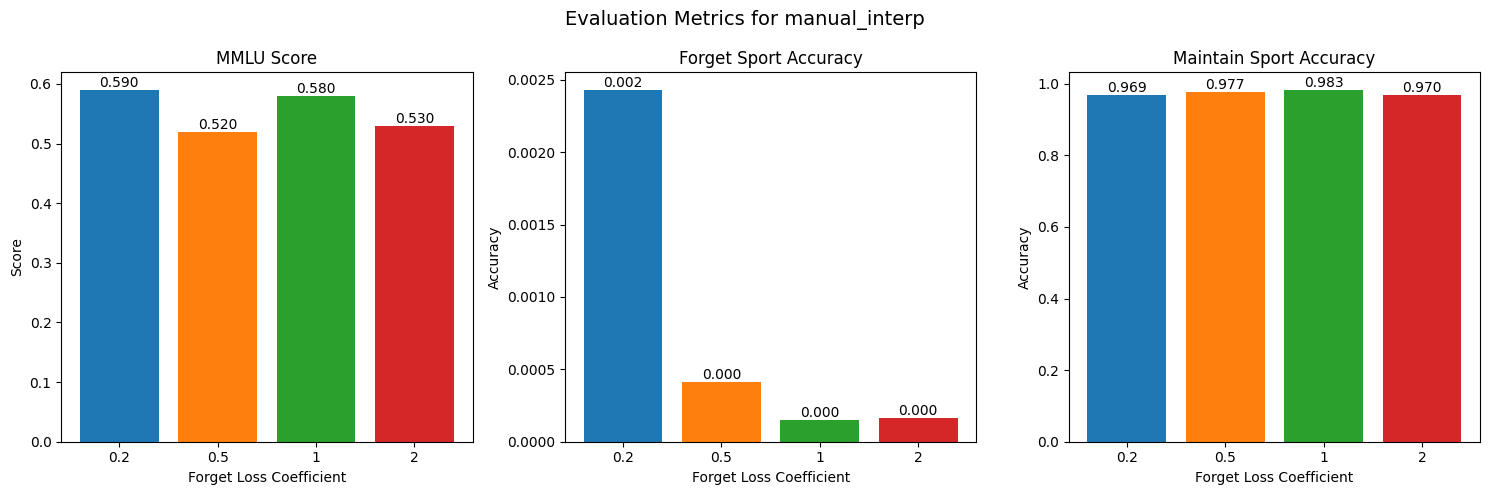

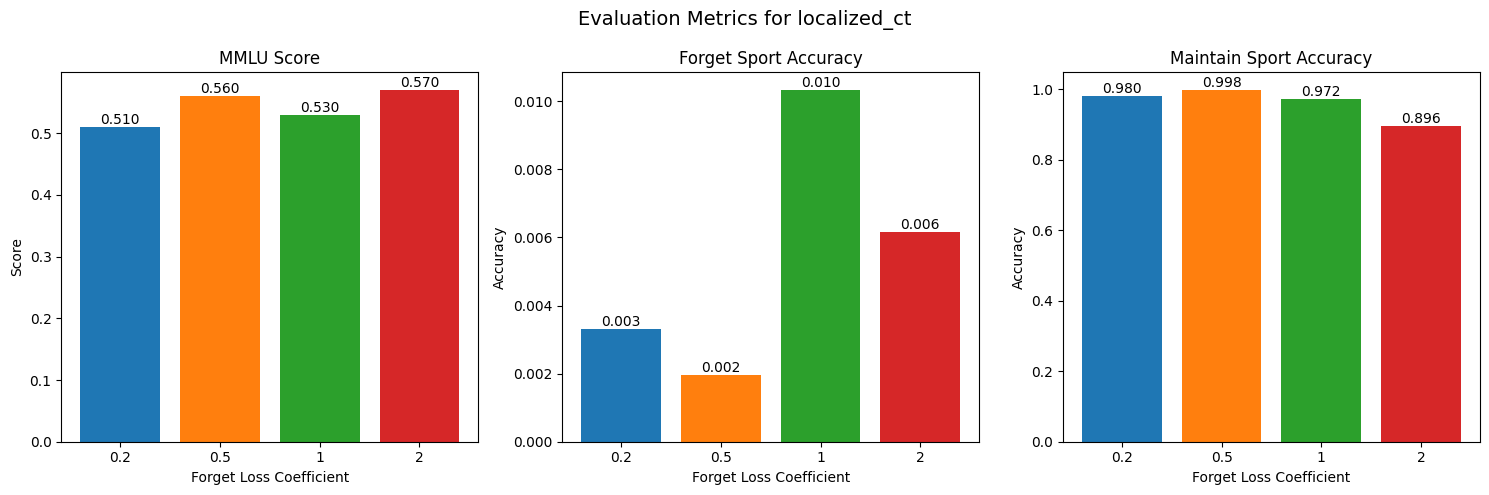

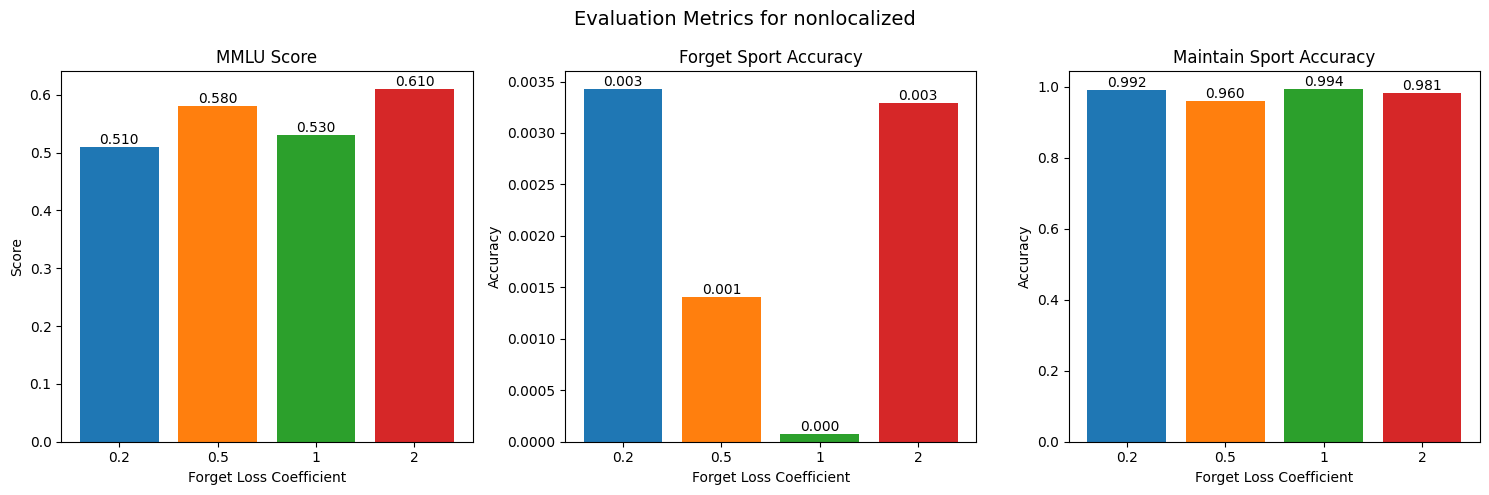

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up colors for learning rates
fc_colors = {
    "0.2": "#1f77b4",  # blue
    "0.5": "#ff7f0e",  # orange
    "1": "#2ca02c",  # green
    "2": "#d62728"   # red
}

# Create a figure for each localization type
for localization_type in side_effects_evals_df["localization_type"].unique():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Evaluation Metrics for {localization_type}', fontsize=14)
    
    # Plot 1: MMLU scores
    mmlu_data = side_effects_evals_df[
        (side_effects_evals_df["localization_type"] == localization_type) & 
        (side_effects_evals_df["task_name"] == "General")
    ]
    bars1 = ax1.bar(mmlu_data["fc"], mmlu_data["MMLU"], color=[fc_colors[fc] for fc in mmlu_data["fc"]])
    ax1.set_title('MMLU Score')
    ax1.set_xlabel('Forget Loss Coefficient')
    ax1.set_ylabel('Score')
    
    # Plot 2: Forget Accuracy
    forget_data = test_losses_df[
        (test_losses_df["localization_type"] == localization_type) & 
        (test_losses_df["task_name"] == "forget_sport_accuracy")
    ]
    bars2 = ax2.bar(forget_data["fc"], forget_data["test_loss"], color=[fc_colors[fc] for fc in forget_data["fc"]])
    ax2.set_title('Forget Sport Accuracy')
    ax2.set_xlabel('Forget Loss Coefficient')
    ax2.set_ylabel('Accuracy')
    
    # Plot 3: Maintain Accuracy
    maintain_data = test_losses_df[
        (test_losses_df["localization_type"] == localization_type) & 
        (test_losses_df["task_name"] == "maintain_sport_accuracy")
    ]
    bars3 = ax3.bar(maintain_data["fc"], maintain_data["test_loss"], color=[fc_colors[fc] for fc in maintain_data["fc"]])
    ax3.set_title('Maintain Sport Accuracy')
    ax3.set_xlabel('Forget Loss Coefficient')
    ax3.set_ylabel('Accuracy')
    
    # Add value labels on top of each bar
    def add_value_labels(ax, bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom')
    
    add_value_labels(ax1, bars1)
    add_value_labels(ax2, bars2)
    add_value_labels(ax3, bars3)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

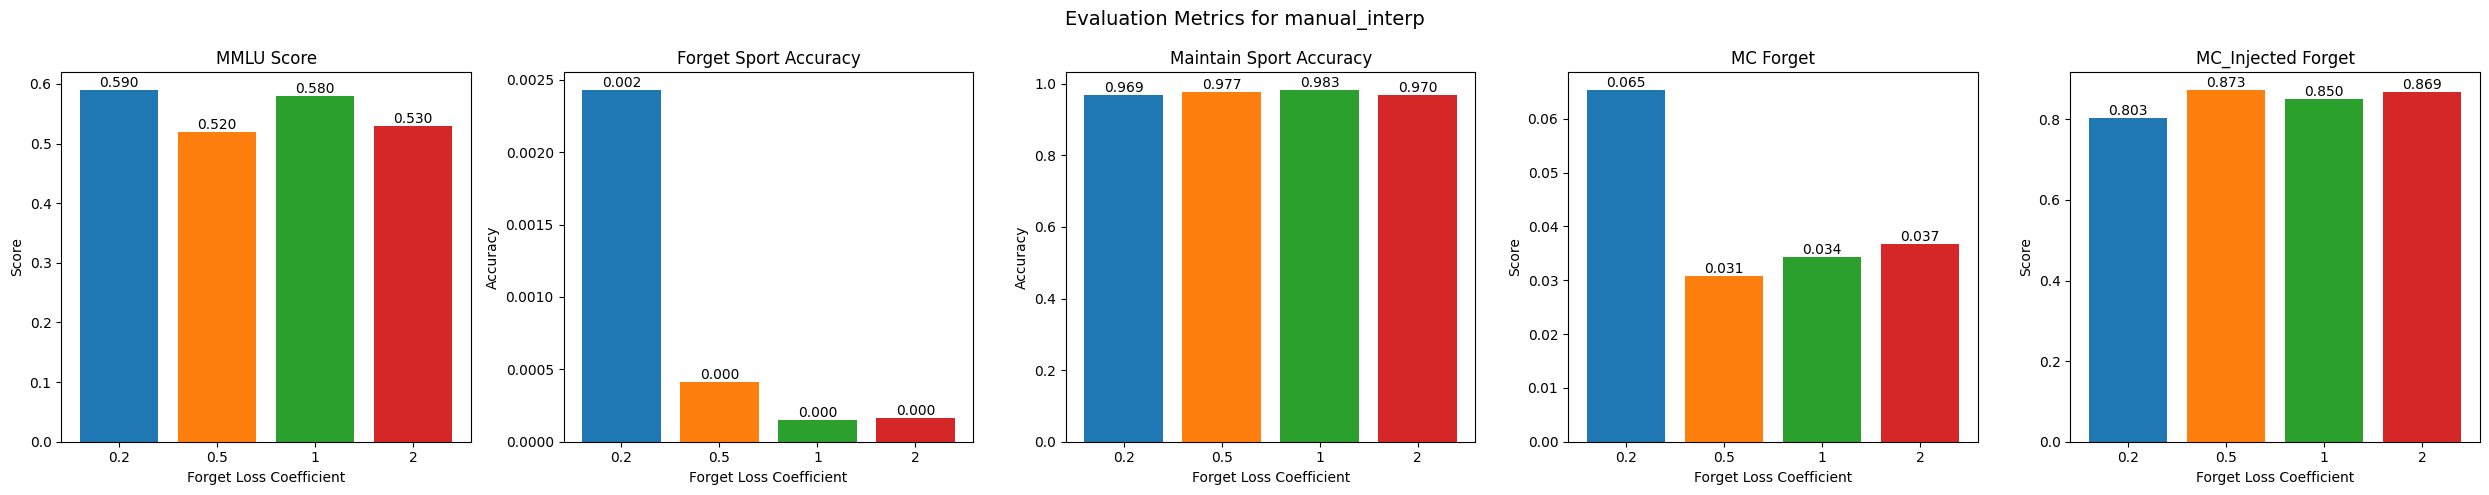

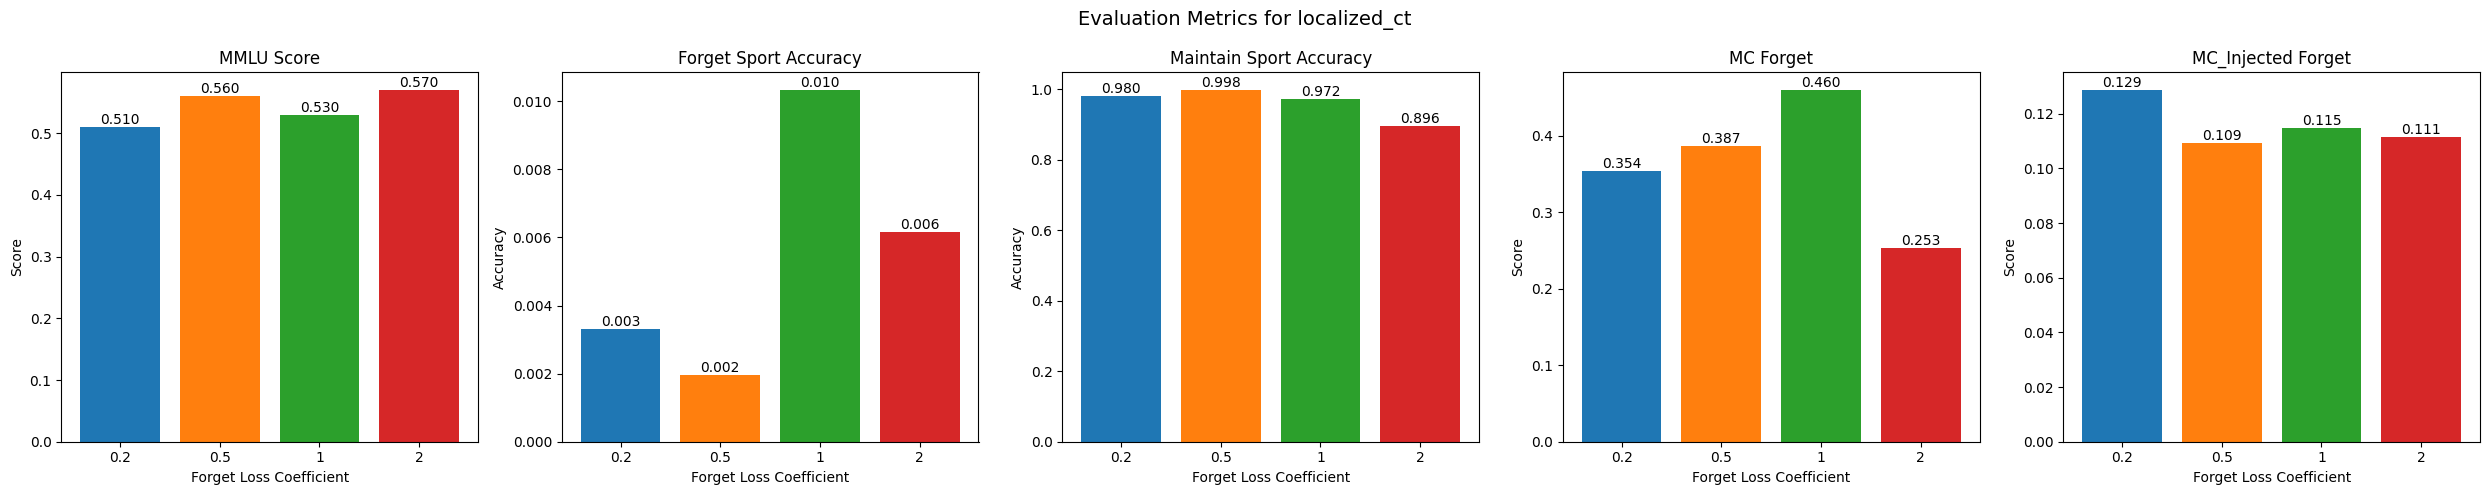

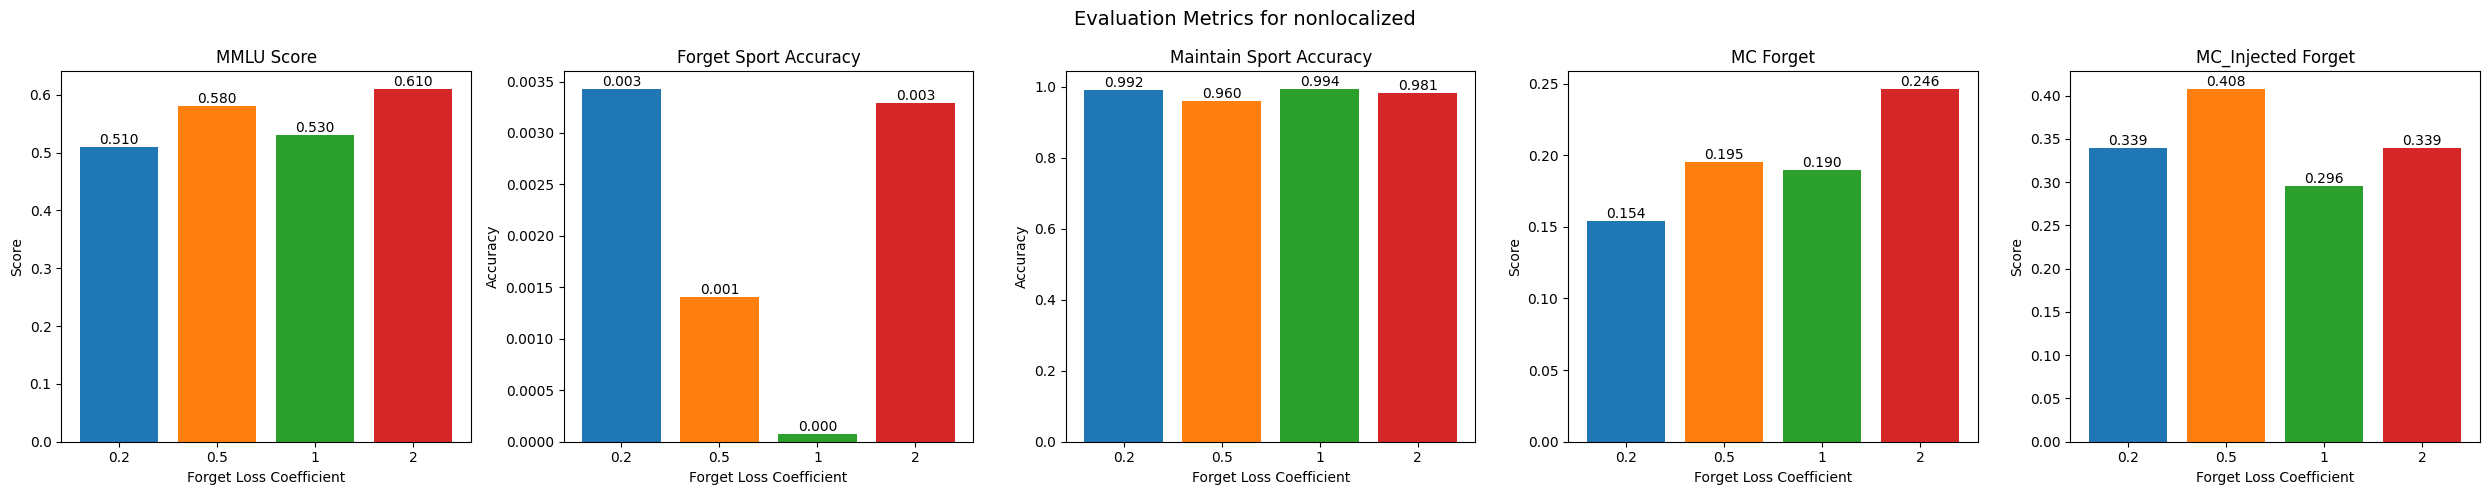

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up colors for learning rates
fc_colors = {
    "0.2": "#1f77b4",  # blue
    "0.5": "#ff7f0e",  # orange
    "1": "#2ca02c",  # green
    "2": "#d62728"   # red
}

# Create a figure for each localization type
for localization_type in side_effects_evals_df["localization_type"].unique():
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 5))
    fig.suptitle(f'Evaluation Metrics for {localization_type}', fontsize=14)
    
    # Plot 1: MMLU scores
    mmlu_data = side_effects_evals_df[
        (side_effects_evals_df["localization_type"] == localization_type) & 
        (side_effects_evals_df["task_name"] == "General")
    ]
    bars1 = ax1.bar(mmlu_data["fc"], mmlu_data["MMLU"], color=[fc_colors[fc] for fc in mmlu_data["fc"]])
    ax1.set_title('MMLU Score')
    ax1.set_xlabel('Forget Loss Coefficient')
    ax1.set_ylabel('Score')
    
    # Plot 2: Forget Accuracy
    forget_data = test_losses_df[
        (test_losses_df["localization_type"] == localization_type) & 
        (test_losses_df["task_name"] == "forget_sport_accuracy")
    ]
    bars2 = ax2.bar(forget_data["fc"], forget_data["test_loss"], color=[fc_colors[fc] for fc in forget_data["fc"]])
    ax2.set_title('Forget Sport Accuracy')
    ax2.set_xlabel('Forget Loss Coefficient')
    ax2.set_ylabel('Accuracy')
    
    # Plot 3: Maintain Accuracy
    maintain_data = test_losses_df[
        (test_losses_df["localization_type"] == localization_type) & 
        (test_losses_df["task_name"] == "maintain_sport_accuracy")
    ]
    bars3 = ax3.bar(maintain_data["fc"], maintain_data["test_loss"], color=[fc_colors[fc] for fc in maintain_data["fc"]])
    ax3.set_title('Maintain Sport Accuracy')
    ax3.set_xlabel('Forget Loss Coefficient')
    ax3.set_ylabel('Accuracy')
    
    # Plot 4: MC Forget
    mc_data = adversarial_evals_df[
        (adversarial_evals_df["localization_type"] == localization_type) & 
        (adversarial_evals_df["eval_type"] == "MC")
    ]
    bars4 = ax4.bar(mc_data["fc"], mc_data["forget"], color=[fc_colors[fc] for fc in mc_data["fc"]])
    ax4.set_title('MC Forget')
    ax4.set_xlabel('Forget Loss Coefficient')
    ax4.set_ylabel('Score')
    
    # Plot 5: MC_Injected Forget
    mc_injected_data = adversarial_evals_df[
        (adversarial_evals_df["localization_type"] == localization_type) & 
        (adversarial_evals_df["eval_type"] == "MC_Injected")
    ]
    bars5 = ax5.bar(mc_injected_data["fc"], mc_injected_data["forget"], color=[fc_colors[fc] for fc in mc_injected_data["fc"]])
    ax5.set_title('MC_Injected Forget')
    ax5.set_xlabel('Forget Loss Coefficient')
    ax5.set_ylabel('Score')
    
    # Add value labels on top of each bar
    def add_value_labels(ax, bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom')
    
    add_value_labels(ax1, bars1)
    add_value_labels(ax2, bars2)
    add_value_labels(ax3, bars3)
    add_value_labels(ax4, bars4)
    add_value_labels(ax5, bars5)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [25]:
# for each localization type, rank forget loss coefficients by average rank across the 5 evaluations
forget_loss_coef_ranks = {}

for localization_type in side_effects_evals_df["localization_type"].unique():
    # Get data for each metric
    mmlu_data = side_effects_evals_df[
        (side_effects_evals_df["localization_type"] == localization_type) & 
        (side_effects_evals_df["task_name"] == "General")
    ].sort_values("fc") # rank by MMLU column
    
    forget_data = test_losses_df[
        (test_losses_df["localization_type"] == localization_type) & 
        (test_losses_df["task_name"] == "forget_sport_accuracy")
    ].sort_values("fc") # rank by test_loss column
    
    maintain_data = test_losses_df[
        (test_losses_df["localization_type"] == localization_type) & 
        (test_losses_df["task_name"] == "maintain_sport_accuracy")
    ].sort_values("fc") # rank by test_loss column
    
    mc_data = adversarial_evals_df[
        (adversarial_evals_df["localization_type"] == localization_type) & 
        (adversarial_evals_df["eval_type"] == "MC")
    ].sort_values("fc") # rank by forget column
    
    mc_injected_data = adversarial_evals_df[
        (adversarial_evals_df["localization_type"] == localization_type) & 
        (adversarial_evals_df["eval_type"] == "MC_Injected")
    ].sort_values("fc") # rank by forget column

    # Rank each fc value for each metric (higher is better for MMLU and maintain and mc_injected, lower is better for others)
    mmlu_ranks = mmlu_data["MMLU"].rank(ascending=False)
    mmlu_ranks.index = mmlu_data["fc"].astype(str)
    forget_ranks = forget_data["test_loss"].rank(ascending=True) 
    forget_ranks.index = forget_data["fc"].astype(str)
    maintain_ranks = maintain_data["test_loss"].rank(ascending=False)
    maintain_ranks.index = maintain_data["fc"].astype(str)
    mc_ranks = mc_data["forget"].rank(ascending=True)
    mc_ranks.index = mc_data["fc"].astype(str)
    mc_injected_ranks = mc_injected_data["forget"].rank(ascending=False)
    mc_injected_ranks.index = mc_injected_data["fc"].astype(str)

    # print(f"mmlu_data = {mmlu_data}")
    # print(f"mmlu_ranks = {mmlu_ranks}")
    # Calculate average rank for each fc
    # avg_ranks = pd.concat([
    #     mmlu_ranks, 
    #     forget_ranks,
    #     maintain_ranks,
    #     mc_ranks,
    #     mc_injected_ranks
    # ], axis=1)

    average_ranks = (mmlu_ranks + forget_ranks + maintain_ranks + mc_ranks + mc_injected_ranks) / 5
    print(f"{average_ranks=}")
    
    forget_loss_coef_ranks[localization_type] = average_ranks

average_ranks=fc
0.2    3.4
0.5    2.2
1      1.8
2      2.6
dtype: float64
average_ranks=fc
0.2    2.2
0.5    2.2
1      3.2
2      2.4
dtype: float64
average_ranks=fc
0.2    2.6
0.5    2.4
1      2.2
2      2.8
dtype: float64


In [27]:
# For each localization type, compute average standardized score across the 5 evaluations
forget_loss_coef_scores = {}

for localization_type in side_effects_evals_df["localization_type"].unique():
    # Get data for each metric
    mmlu_data = side_effects_evals_df[
        (side_effects_evals_df["localization_type"] == localization_type) & 
        (side_effects_evals_df["task_name"] == "General")
    ].sort_values("fc")
    
    forget_data = test_losses_df[
        (test_losses_df["localization_type"] == localization_type) & 
        (test_losses_df["task_name"] == "forget_sport_accuracy")
    ].sort_values("fc")
    
    maintain_data = test_losses_df[
        (test_losses_df["localization_type"] == localization_type) & 
        (test_losses_df["task_name"] == "maintain_sport_accuracy")
    ].sort_values("fc")
    
    mc_data = adversarial_evals_df[
        (adversarial_evals_df["localization_type"] == localization_type) & 
        (adversarial_evals_df["eval_type"] == "MC")
    ].sort_values("fc")
    
    mc_injected_data = adversarial_evals_df[
        (adversarial_evals_df["localization_type"] == localization_type) & 
        (adversarial_evals_df["eval_type"] == "MC_Injected")
    ].sort_values("fc")

    # Standardize each metric (higher is better for MMLU and maintain, lower is better for others)
    def standardize(series, higher_is_better=True):
        min_val = series.min()
        max_val = series.max()
        if max_val == min_val:
            return pd.Series([0.5] * len(series), index=series.index)
        standardized = (series - min_val) / (max_val - min_val)
        return standardized if higher_is_better else (1 - standardized)

    mmlu_scores = standardize(mmlu_data["MMLU"], higher_is_better=True)
    mmlu_scores.index = mmlu_data["fc"].astype(str)
    
    forget_scores = standardize(forget_data["test_loss"], higher_is_better=False)
    forget_scores.index = forget_data["fc"].astype(str)
    
    maintain_scores = standardize(maintain_data["test_loss"], higher_is_better=True)
    maintain_scores.index = maintain_data["fc"].astype(str)
    
    mc_scores = standardize(mc_data["forget"], higher_is_better=False)
    mc_scores.index = mc_data["fc"].astype(str)
    
    mc_injected_scores = standardize(mc_injected_data["forget"], higher_is_better=True)
    mc_injected_scores.index = mc_injected_data["fc"].astype(str)

    # Calculate average standardized score
    average_scores = (mmlu_scores + forget_scores + maintain_scores + mc_scores + mc_injected_scores)
    print(f"\n{localization_type} scores:")
    for fc, score in average_scores.items():
        print(f"FC {fc}: {score:.3f}")
    
    forget_loss_coef_scores[localization_type] = average_scores


manual_interp scores:
FC 0.2: 1.000
FC 0.5: 3.456
FC 1: 4.425
FC 2: 2.992

localized_ct scores:
FC 0.2: 3.177
FC 0.5: 3.185
FC 1: 1.370
FC 2: 2.610

nonlocalized scores:
FC 0.2: 2.333
FC 0.5: 2.859
FC 1: 2.814
FC 2: 2.061


In [11]:
forget_loss_coef_ranks

{'manual_interp': 0      3.5
 1      3.5
 2      3.5
 3      3.5
 4      3.5
 5      3.5
 18     9.5
 19     9.5
 20     9.5
 21     9.5
 22     9.5
 23     9.5
 36    15.5
 37    15.5
 38    15.5
 39    15.5
 40    15.5
 41    15.5
 54    21.5
 55    21.5
 56    21.5
 57    21.5
 58    21.5
 59    21.5
 Name: fc, dtype: float64,
 'localized_ct': 6      3.5
 7      3.5
 8      3.5
 9      3.5
 10     3.5
 11     3.5
 24     9.5
 25     9.5
 26     9.5
 27     9.5
 28     9.5
 29     9.5
 42    15.5
 43    15.5
 44    15.5
 45    15.5
 46    15.5
 47    15.5
 60    21.5
 61    21.5
 62    21.5
 63    21.5
 64    21.5
 65    21.5
 Name: fc, dtype: float64,
 'nonlocalized': 12     3.5
 13     3.5
 14     3.5
 15     3.5
 16     3.5
 17     3.5
 30     9.5
 31     9.5
 32     9.5
 33     9.5
 34     9.5
 35     9.5
 48    15.5
 49    15.5
 50    15.5
 51    15.5
 52    15.5
 53    15.5
 66    21.5
 67    21.5
 68    21.5
 69    21.5
 70    21.5
 71    21.5
 Name: fc, dtype: float64}

## Make Graphs

### General Performance (tables)

In [6]:
from scipy.stats import sem

# Perform the groupby operations
forget_fact_accuracy = test_losses_df.query("task_name == 'forget_fact_accuracy'").groupby("localization_type")['test_loss'].mean()
maintain_fact_accuracy = test_losses_df.query("task_name == 'maintain_fact_accuracy'").groupby("localization_type")['test_loss'].mean()
mmlu_acc_mean = mmlu_acc_df.groupby("localization_type")['mmlu_acc'].mean()
# mmlu_acc_sem = mmlu_acc_df.groupby("localization_type")['mmlu_acc'].apply(sem) * (mmlu_acc_df.groupby("localization_type")["mmlu_acc"].count() - 1)
mc_forget_mean = adversarial_evals_df.query("eval_type == 'MC'").groupby("localization_type")['forget'].mean()
paraphrase_forget_mean = adversarial_evals_df.query("eval_type == 'Paraphrase'").groupby("localization_type")['forget'].mean()
neighborhood_forget_mean = adversarial_evals_df.query("eval_type == 'Neighborhood'").groupby("localization_type")['forget'].mean()

# Concatenate the results into one DataFrame
combined_df = pd.concat([forget_fact_accuracy, maintain_fact_accuracy, mmlu_acc_mean, mc_forget_mean, paraphrase_forget_mean, neighborhood_forget_mean], axis=1)
combined_df.columns = ['forget_fact_accuracy', 'maintain_fact_accuracy', 'mmlu_acc_mean', 'mc_forget_mean', 'paraphrase_forget_mean', 'neighborhood_forget_mean']

print(f"For {forget_facts=}, {inject_fact=}")
# Display the combined DataFrame
display(combined_df)

For forget_facts=16, inject_fact=True


,forget_fact_accuracy,maintain_fact_accuracy,mmlu_acc_mean,mc_forget_mean,paraphrase_forget_mean,neighborhood_forget_mean
localization_type,,,,,,
all_mlps,0.000120,0.926628,0.687628,0.389935,0.083319,0.724873
forget_ap,0.000117,0.974189,0.690903,0.943678,0.286443,0.681255
manual_interp,0.000030,0.965057,0.691378,0.294677,0.034569,0.733265
new_forget_ct,0.000024,0.973046,0.691734,0.481209,0.031631,0.736296
nonlocalized,0.000107,0.920397,0.681788,0.411491,0.103592,0.745817
random,0.000052,0.979288,0.690073,0.650512,0.159196,0.757015


### Bar Graph

In [36]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.colors as mcolors
import numpy as np

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('Forget Fact Accuracy', 'MC Forget Mean'))

# Define color map and rename "new_forget_ct"
color_map = {
    "new_forget_ct": mcolors.to_hex(mcolors.TABLEAU_COLORS['tab:orange']),  # C1 in matplotlib
    "manual_interp": mcolors.to_hex(mcolors.TABLEAU_COLORS['tab:green']),   # C3 in matplotlib
    "nonlocalized": mcolors.to_hex(mcolors.TABLEAU_COLORS['tab:red'])       # C4 in matplotlib
}
name_map = {
    "new_forget_ct": "Causal Tracing",
    "manual_interp": "Manual Interp",
    "nonlocalized": "Nonlocalized"
}

# Filter the data to include only the specified localization types
filtered_df = combined_df.loc[list(name_map.keys())]

# Data
localization_types = filtered_df.index
forget_fact_accuracy = filtered_df['forget_fact_accuracy']
mc_forget_mean = filtered_df['mc_forget_mean']

# Function to get color
def get_color(localization_type):
    return color_map[localization_type]

# Function to get name
def get_name(localization_type):
    return name_map[localization_type]

# Function to adjust near-zero values
def adjust_near_zero(values, min_height=0.01):
    return np.maximum(values, min_height)

# Add bars for forget_fact_accuracy
fig.add_trace(
    go.Bar(
        x=[get_name(lt) for lt in localization_types],
        y=adjust_near_zero(forget_fact_accuracy),
        text=forget_fact_accuracy.round(3),
        textposition='outside',
        name='Forget Fact Accuracy',
        marker_color=[get_color(lt) for lt in localization_types],
        textfont=dict(size=14)
    ),
    row=1, col=1
)

# Add bars for mc_forget_mean
fig.add_trace(
    go.Bar(
        x=[get_name(lt) for lt in localization_types],
        y=adjust_near_zero(mc_forget_mean),
        text=mc_forget_mean.round(3),
        textposition='outside',
        name='MC Forget Mean',
        marker_color=[get_color(lt) for lt in localization_types],
        textfont=dict(size=14)
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    height=700,  # Increased height to accommodate the new text
    width=1000,
    title_text=f"Forget Fact Accuracy and MC Forget Mean (forget_facts={forget_facts}, inject_fact={inject_fact})",
    title_font=dict(size=20),
    showlegend=False,
    yaxis=dict(range=[0, 1], title='Accuracy', title_font=dict(size=16), tickfont=dict(size=14)),
    yaxis2=dict(range=[0, 1], title='Mean', title_font=dict(size=16), tickfont=dict(size=14)),
    font=dict(size=14),  # This sets a base font size for all text
    margin=dict(b=150),  # Increase bottom margin to make room for the text
)

# Update x-axis
fig.update_xaxes(tickangle=45, tickfont=dict(size=14))

# Update subplot titles
for i in fig['layout']['annotations']:
    i['font'] = dict(size=18)

# Add explanatory text at the bottom
fig.add_annotation(
    text="Shorter bars are edited models that say the original answer less, corresponding to stronger editing",
    xref="paper", yref="paper",
    x=0.5, y=-0.28,  # Positioned at the bottom center
    showarrow=False,
    font=dict(size=16),
    align="center",
)

# Show plot
fig.show()

In [45]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.colors as mcolors
import numpy as np

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('Original Prompt Format', 'Multiple Choice Prompt Format'))

# Define color map and rename "new_forget_ct"
color_map = {
    "new_forget_ct": "#FFA500",  # Standard orange
    "manual_interp": "#FF6347",  # Tomato (a softer red)
    "nonlocalized": "#8A2BE2"    # Blue Violet (a vibrant purple)
}
name_map = {
    "new_forget_ct": "Causal Tracing",
    "manual_interp": "Manual Interp",
    "nonlocalized": "No Localization"
}

# Filter the data to include only the specified localization types
filtered_df = combined_df.loc[list(name_map.keys())]

# Data
localization_types = filtered_df.index
forget_fact_accuracy = filtered_df['forget_fact_accuracy']
mc_forget_mean = filtered_df['mc_forget_mean']

# Function to get color
def get_color(localization_type):
    return color_map[localization_type]

# Function to get name
def get_name(localization_type):
    return name_map[localization_type]

# Function to adjust near-zero values
def adjust_near_zero(values, min_height=0.01):
    return np.maximum(values, min_height)

# Add bars for forget_fact_accuracy
fig.add_trace(
    go.Bar(
        x=[get_name(lt) for lt in localization_types],
        y=adjust_near_zero(forget_fact_accuracy),
        text=forget_fact_accuracy.round(3),
        textposition='outside',
        name='Forget Fact Accuracy',
        marker_color=[get_color(lt) for lt in localization_types],
        textfont=dict(size=14)
    ),
    row=1, col=1
)

# Add bars for mc_forget_mean
fig.add_trace(
    go.Bar(
        x=[get_name(lt) for lt in localization_types],
        y=adjust_near_zero(mc_forget_mean),
        text=mc_forget_mean.round(3),
        textposition='outside',
        name='MC Forget Mean',
        marker_color=[get_color(lt) for lt in localization_types],
        textfont=dict(size=14)
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    height=700,  # Increased height to accommodate the new text
    width=1000,
    title_text=f"Edited Model Accuracy on Ground Truth Answers, CounterFact",
    title_font=dict(size=20),
    showlegend=False,
    yaxis=dict(range=[0, 1], title='Accuracy', title_font=dict(size=16), tickfont=dict(size=14)),
    yaxis2=dict(range=[0, 1], title='Mean', title_font=dict(size=16), tickfont=dict(size=14)),
    font=dict(size=14),  # This sets a base font size for all text
    margin=dict(b=150),  # Increase bottom margin to make room for the text
)

# Update x-axis
fig.update_xaxes(tickangle=45, tickfont=dict(size=14))

# Update subplot titles
for i in fig['layout']['annotations']:
    i['font'] = dict(size=18)

# Add explanatory text at the bottom
fig.add_annotation(
    text="Lower is better: Methods with stronger editing should have lower accuracy on ground truth answers, across prompt formats",
    xref="paper", yref="paper",
    x=0.5, y=-0.28,  # Positioned at the bottom center
    showarrow=False,
    font=dict(size=16),
    align="center",
)

# Show plot
fig.show()

In [57]:
import plotly.graph_objects as go
import numpy as np

# Define color map and rename "new_forget_ct"
color_map = {
    "new_forget_ct": "#FFA500",  # Standard orange
    "manual_interp": "#FF6347",  # Tomato (a softer red)
    "nonlocalized": "#8A2BE2"    # Blue Violet (a vibrant purple)
}
name_map = {
    "new_forget_ct": "Causal Tracing",
    "manual_interp": "Manual Interp",
    "nonlocalized": "No Localization"
}

# Filter the data to include only the specified localization types
filtered_df = combined_df.loc[list(name_map.keys())]

# Data
localization_types = filtered_df.index
forget_fact_accuracy = filtered_df['forget_fact_accuracy']
mc_forget_mean = filtered_df['mc_forget_mean']

# Function to get color
def get_color(localization_type):
    return color_map[localization_type]

# Function to get name
def get_name(localization_type):
    return name_map[localization_type]

# Function to adjust near-zero values
def adjust_near_zero(values, min_height=0.03):
    return np.maximum(values, min_height)

# Create figure
fig = go.Figure()

# Add bars for forget_fact_accuracy (Original Prompt Format) and mc_forget_mean (Multiple Choice)
for i, lt in enumerate(localization_types):
    fig.add_trace(
        go.Bar(
            x=[get_name(lt)],
            y=[adjust_near_zero(forget_fact_accuracy[lt])],
            text=[f"{forget_fact_accuracy[lt]:.3f}"],
            textposition='outside',
            name='Original Prompt Format' if i == 0 else None,
            marker_color=get_color(lt),
            textfont=dict(size=14),
            offsetgroup=0,
            showlegend=i == 0
        )
    )
    fig.add_trace(
        go.Bar(
            x=[get_name(lt)],
            y=[adjust_near_zero(mc_forget_mean[lt])],
            text=[f"{mc_forget_mean[lt]:.3f}"],
            textposition='outside',
            name='Multiple Choice' if i == 0 else None,
            marker_color=get_color(lt),
            marker_pattern_shape="/",
            textfont=dict(size=14),
            offsetgroup=1,
            showlegend=i == 0
        )
    )

# Update layout
fig.update_layout(
    height=500, width=1000,
    title_text="Edited Model Accuracy on Ground Truth Answers, CounterFact",
    title_font=dict(size=20),
    showlegend=True,
    yaxis=dict(range=[0, 0.6], title='Accuracy', title_font=dict(size=16), tickfont=dict(size=14)),
    font=dict(size=14),  # This sets a base font size for all text
    margin=dict(b=150),  # Increase bottom margin to make room for the text
    barmode='group',  # Group bars for each localization type
    bargap=0.2,  # Gap between bar groups
    bargroupgap=0.05  # Gap between bars within a group
)

# Update x-axis
fig.update_xaxes(tickangle=45, tickfont=dict(size=14))

# Add explanatory text at the bottom
fig.add_annotation(
    text="Lower is better: Robustly edited models should have lower accuracy on ground truth answers, across prompt formats",
    xref="paper", yref="paper",
    x=0.5, y=-0.5,  # Positioned lower to avoid overlap
    showarrow=False,
    font=dict(size=15),
    align="center",
)

# Update legend
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
        bgcolor="rgba(255, 255, 255, 0.5)",  # Semi-transparent white background
    )
)

# Show plot
fig.show()

In [58]:
import plotly.graph_objects as go
import numpy as np

# Define color map and rename "new_forget_ct"
color_map = {
    "new_forget_ct": "#FFA500",  # Standard orange
    "manual_interp": "#FF6347",  # Tomato (a softer red)
    "nonlocalized": "#8A2BE2"    # Blue Violet (a vibrant purple)
}
name_map = {
    "new_forget_ct": "Causal Tracing",
    "manual_interp": "Manual Interp",
    "nonlocalized": "No Localization"
}

# Filter the data to include only the specified localization types
filtered_df = combined_df.loc[list(name_map.keys())]

# Data
localization_types = filtered_df.index
forget_fact_accuracy = filtered_df['forget_fact_accuracy']
mc_forget_mean = filtered_df['mc_forget_mean']

# Function to get color
def get_color(localization_type):
    return color_map[localization_type]

# Function to get name
def get_name(localization_type):
    return name_map[localization_type]

# Function to adjust near-zero values
def adjust_near_zero(values, min_height=0.03):
    return np.maximum(values, min_height)

# Create figure
fig = go.Figure()

# Add bars for forget_fact_accuracy (Original Prompt Format) and mc_forget_mean (Multiple Choice)
for i, lt in enumerate(localization_types):
    fig.add_trace(
        go.Bar(
            x=[get_name(lt)],
            y=[adjust_near_zero(forget_fact_accuracy[lt])],
            text=[f"{forget_fact_accuracy[lt]*100:.1f}%"],
            textposition='outside',
            name='Original Prompt Format' if i == 0 else None,
            marker_color=get_color(lt),
            textfont=dict(size=14),
            offsetgroup=0,
            showlegend=i == 0
        )
    )
    fig.add_trace(
        go.Bar(
            x=[get_name(lt)],
            y=[adjust_near_zero(mc_forget_mean[lt])],
            text=[f"{mc_forget_mean[lt]*100:.1f}%"],
            textposition='outside',
            name='Multiple Choice' if i == 0 else None,
            marker_color=get_color(lt),
            marker_pattern_shape="/",
            textfont=dict(size=14),
            offsetgroup=1,
            showlegend=i == 0
        )
    )

# Update layout
fig.update_layout(
    height=500, width=1000,
    title_text="Edited Model Accuracy on Ground Truth Answers, CounterFact",
    title_font=dict(size=20),
    showlegend=True,
    yaxis=dict(
        range=[0, 0.6], 
        title='Accuracy', 
        title_font=dict(size=16), 
        tickfont=dict(size=14),
        tickformat='.0%'  # Format y-axis ticks as percentages
    ),
    font=dict(size=14),  # This sets a base font size for all text
    margin=dict(b=150),  # Increase bottom margin to make room for the text
    barmode='group',  # Group bars for each localization type
    bargap=0.2,  # Gap between bar groups
    bargroupgap=0.05  # Gap between bars within a group
)

# Update x-axis
fig.update_xaxes(tickangle=45, tickfont=dict(size=14))

# Add explanatory text at the bottom
fig.add_annotation(
    text="Lower is better: Robustly edited models should have lower accuracy on ground truth answers, across prompt formats",
    xref="paper", yref="paper",
    x=0.5, y=-0.5,  # Positioned lower to avoid overlap
    showarrow=False,
    font=dict(size=15),
    align="center",
)

# Update legend
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
        bgcolor="rgba(255, 255, 255, 0.5)",  # Semi-transparent white background
    )
)

# Show plot
fig.show()

### Plot Relearning

In [6]:
relearning_results_df.query("localization_type == 'manual_interp'")

,localization_type,run_id,step,mmlu,forget,maintain,mc_forget,mc_maintain
0,manual_interp,11,0,0.73,0.086349,0.962176,0.488232,0.910541
1,manual_interp,11,1,0.74,0.155722,0.942798,0.439670,0.935794
2,manual_interp,11,2,0.73,0.197150,0.965202,0.475497,0.924125
3,manual_interp,11,3,0.74,0.311863,0.930992,0.466220,0.899577
4,manual_interp,11,4,0.75,0.404656,0.925984,0.487180,0.905774
5,manual_interp,11,5,0.75,0.496294,0.892668,0.495260,0.870203
6,manual_interp,11,6,0.75,0.561676,0.887248,0.562269,0.891703
7,manual_interp,11,7,0.74,0.606783,0.893113,0.513383,0.874591
8,manual_interp,11,8,0.75,0.658951,0.870812,0.557828,0.859263
9,manual_interp,11,9,0.75,0.698410,0.918633,0.563360,0.882757


In [7]:
adversarial_evals_df.pivot(index=['localization_type', 'run_id'], columns='eval_type', values=['forget', 'maintain'])

forget                                    \
eval_type                       MC Neighborhood    Normal Paraphrase   
localization_type run_id                                               
all_mlps          11      0.461190     0.719066  0.000737   0.093599   
                  12      0.625255     0.672613  0.001301   0.111767   
                  13      0.709503     0.722012  0.000293   0.065641   
forget_ap         11      0.931407     0.717214  0.001773   0.328885   
                  12      0.939931     0.690253  0.000700   0.278830   
                  13      0.936880     0.691618  0.001924   0.263908   
manual_interp     11      0.539511     0.724407  0.001801   0.216807   
                  12      0.576733     0.708595  0.002077   0.101446   
                  13      0.631965     0.724088  0.001592   0.186958   
new_forget_ct     11      0.661130     0.698431  0.000567   0.174603   
                  12      0.659089     0.727177  0.000302   0.168485   
                  13      0.586156     0.728040  0.000435   0.145230   
nonlocalized      11      0.615732     0.683302  0.000116   0.135318   
                  12      0.537826     0.735515  0.000500   0.073189   
                  13      0.598746     0.739368  0.000258   0.090234   
random            11      0.652922     0.702755  0.001553   0.198429   
                  12      0.776724     0.729715  0.000435   0.152754   
                  13      0.738203     0.697378  0.000761   0.229567   

                          maintain                                    
eval_type                       MC Neighborhood    Normal Paraphrase  
localization_type run_id                                              
all_mlps          11      0.924647     0.647518  0.924906   0.697702  
                  12      0.923923     0.652545  0.931397   0.699595  
                  13      0.884738     0.630549  0.926716   0.776274  
forget_ap         11      0.927901     0.656817  0.970347   0.739758  
                  12      0.914906     0.644262  0.976783   0.754325  
                  13      0.907595     0.682120  0.948759   0.743433  
manual_interp     11      0.978094     0.581198  0.963668   0.676021  
                  12      0.957750     0.587604  0.942220   0.618985  
                  13      0.957873     0.616818  0.970213   0.704111  
new_forget_ct     11      0.964562     0.652879  0.964190   0.777720  
                  12      0.977532     0.666920  0.974113   0.721058  
                  13      0.918824     0.631723  0.973924   0.767723  
nonlocalized      11      0.912103     0.660615  0.913815   0.766890  
                  12      0.888131     0.641549  0.915399   0.763650  
                  13      0.747320     0.651614  0.902841   0.776439  
random            11      0.973697     0.692676  0.989567   0.728010  
                  12      0.925685     0.628700  0.973131   0.790154  
                  13      0.957908     0.648279  0.960075   0.726401

In [8]:
adversarial_evals_df

,localization_type,run_id,eval_type,forget,maintain
0,manual_interp,11,Normal,0.001801,0.963668
1,manual_interp,11,MC,0.539511,0.978094
2,manual_interp,11,Paraphrase,0.216807,0.676021
3,manual_interp,11,Neighborhood,0.724407,0.581198
4,new_forget_ct,11,Normal,0.000567,0.964190
...,...,...,...,...,...
67,nonlocalized,13,Neighborhood,0.739368,0.651614
68,random,13,Normal,0.000761,0.960075
69,random,13,MC,0.738203,0.957908
70,random,13,Paraphrase,0.229567,0.726401


/tmp/ipykernel_2486137/2312270900.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_relearning_results_df = pd.concat([relearning_results_df, new_rows], ignore_index=True)


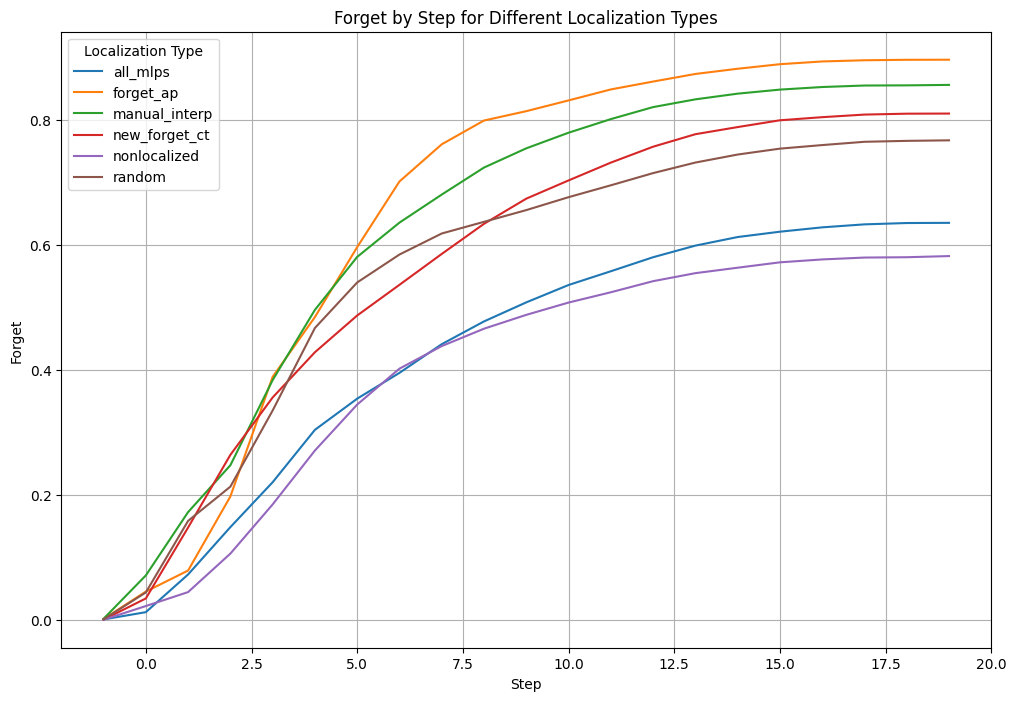

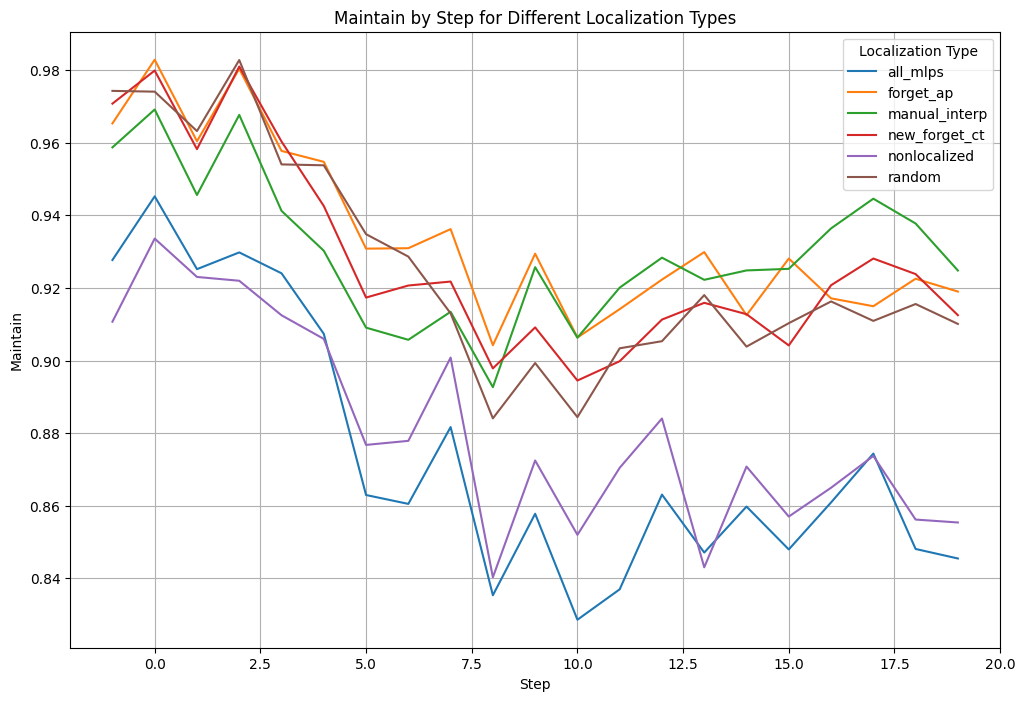

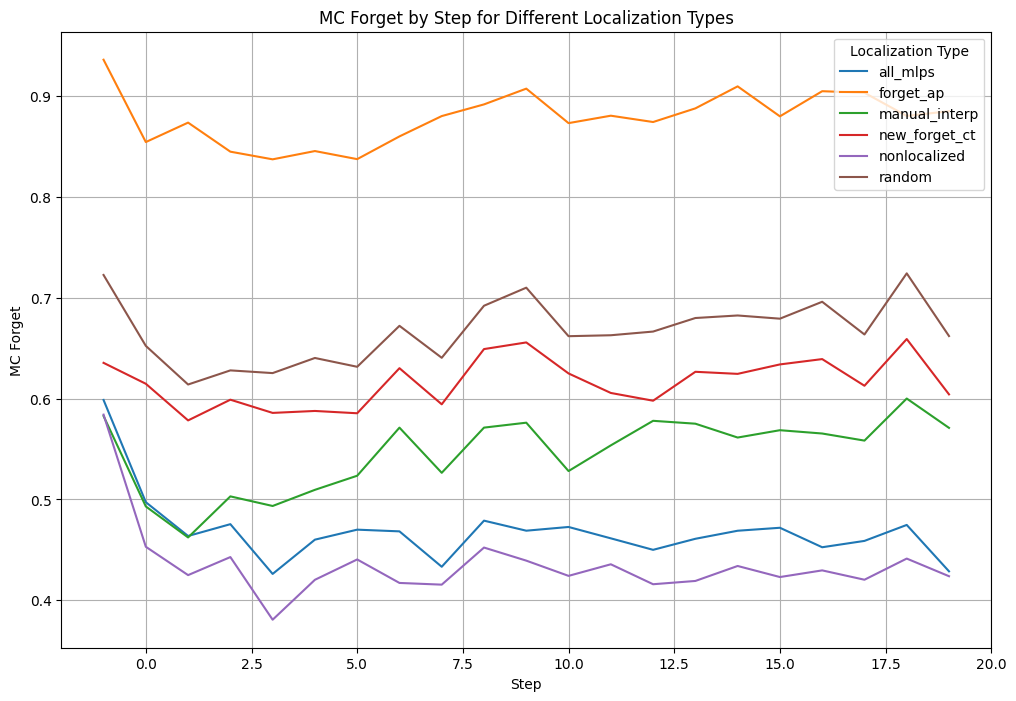

In [9]:
import pandas as pd

# Merge the adversarial_evals_df to get the required columns
merged_df = adversarial_evals_df.pivot(index=['localization_type', 'run_id'], columns='eval_type', values=['forget', 'maintain']).reset_index()
merged_df.columns = ['localization_type', 'run_id', 'forget_MC', 'forget_Neighborhood', 'forget_Normal', 'forget_Paraphrase', 'maintain_MC', 'maintain_Neighborhood', 'maintain_Normal', 'maintain_Paraphrase']

# Create new rows with step = -1
new_rows = merged_df.copy()
new_rows['step'] = -1
new_rows['mmlu'] = None  # Leave mmlu blank
new_rows = new_rows.rename(columns={
    'forget_Normal': 'forget',
    'maintain_Normal': 'maintain',
    'forget_MC': 'mc_forget',
    'maintain_MC': 'mc_maintain'
})

# Select and reorder the columns to match relearning_results_df
new_rows = new_rows[['localization_type', 'run_id', 'step', 'mmlu', 'forget', 'maintain', 'mc_forget', 'mc_maintain']]

# Append the new rows to relearning_results_df
combined_relearning_results_df = pd.concat([relearning_results_df, new_rows], ignore_index=True)

# Display the updated DataFrame
# display(combined_relearning_results_df)

import matplotlib.pyplot as plt

# Group by localization_type and step, then calculate the mean for each metric
mean_metrics = combined_relearning_results_df.groupby(['localization_type', 'step']).mean().reset_index()

# Plotting function
def plot_metric(metric, ylabel):
    plt.figure(figsize=(12, 8))
    for localization_type in mean_metrics['localization_type'].unique():
        subset = mean_metrics[mean_metrics['localization_type'] == localization_type]
        plt.plot(subset['step'], subset[metric], label=localization_type)
    plt.xlabel('Step')
    plt.ylabel(ylabel)
    plt.title(f'{ylabel} by Step for Different Localization Types')
    plt.legend(title='Localization Type')
    plt.grid(True)
    plt.show()

# Plot forget
plot_metric('forget', 'Forget')

# Plot maintain
plot_metric('maintain', 'Maintain')

# Plot mc_forget
plot_metric('mc_forget', 'MC Forget')

# Plot mc_maintain
# plot_metric('mc_maintain', 'MC Maintain')

/tmp/ipykernel_2486137/861840405.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_relearning_results_df = pd.concat([relearning_results_df, new_rows], ignore_index=True)


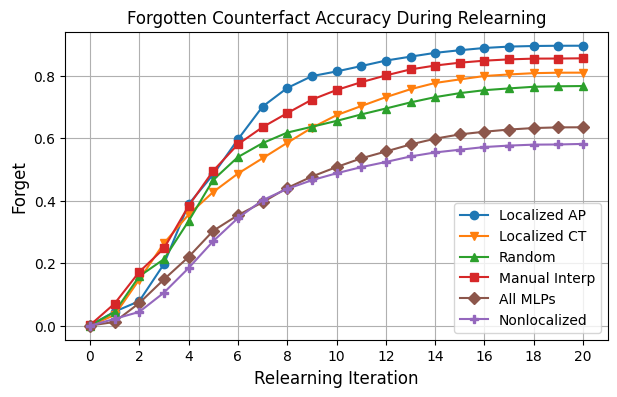

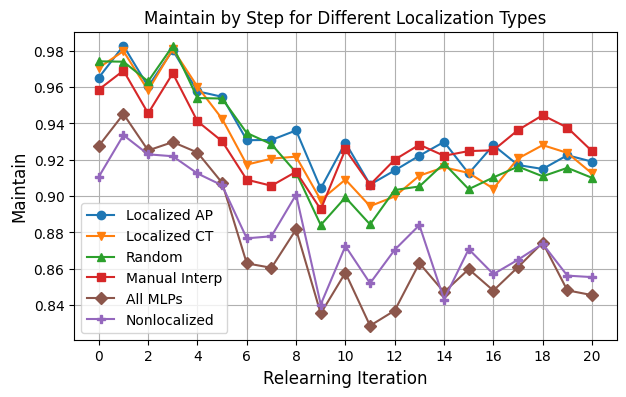

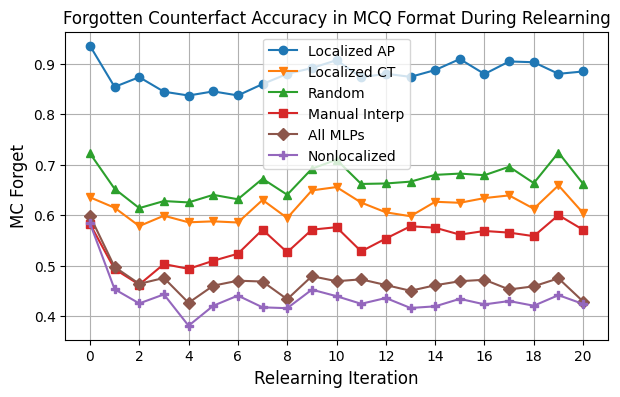

In [10]:
import pandas as pd

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
color_map = {"forget_ap": colors[0], "new_forget_ct": colors[1], "random": colors[2], "manual_interp": colors[3], "nonlocalized": colors[4], "all_mlps": colors[5]}
formal_name_dict = {"forget_ap": "Localized AP", "new_forget_ct": "Localized CT", "random": "Random", "manual_interp": "Manual Interp", "nonlocalized": "Nonlocalized", "all_mlps": "All MLPs"}

type_to_marker = {
    'forget_ap': 'o',
    'new_forget_ct': 'v',
    'random': '^',
    'manual_interp': 's',
    'all_mlps': 'D',
    'nonlocalized': 'P'
}

# Merge the adversarial_evals_df to get the required columns
merged_df = adversarial_evals_df.pivot(index=['localization_type', 'run_id'], columns='eval_type', values=['forget', 'maintain']).reset_index()
merged_df.columns = ['localization_type', 'run_id', 'forget_MC', 'forget_Neighborhood', 'forget_Normal', 'forget_Paraphrase', 'maintain_MC', 'maintain_Neighborhood', 'maintain_Normal', 'maintain_Paraphrase']

# Create new rows with step = -1
new_rows = merged_df.copy()
new_rows['step'] = -1
new_rows['mmlu'] = None  # Leave mmlu blank
new_rows = new_rows.rename(columns={
    'forget_Normal': 'forget',
    'maintain_Normal': 'maintain',
    'forget_MC': 'mc_forget',
    'maintain_MC': 'mc_maintain'
})

# Select and reorder the columns to match relearning_results_df
new_rows = new_rows[['localization_type', 'run_id', 'step', 'mmlu', 'forget', 'maintain', 'mc_forget', 'mc_maintain']]

# Append the new rows to relearning_results_df
combined_relearning_results_df = pd.concat([relearning_results_df, new_rows], ignore_index=True)

# Display the updated DataFrame
# display(combined_relearning_results_df)

import matplotlib.pyplot as plt

# Group by localization_type and step, then calculate the mean for each metric
mean_metrics = combined_relearning_results_df.groupby(['localization_type', 'step']).mean().reset_index()

localization_order = ["forget_ap", "new_forget_ct", "random", "manual_interp", "all_mlps", "nonlocalized"]

# Function to plot relearning results
def plot_relearning_results(mean_metrics, metric, title, ylabel, formal=True):
    plt.figure(figsize=(7, 4))
    # for localization_type in mean_metrics['localization_type'].unique():
    for localization_type in localization_order:
        subset = mean_metrics[mean_metrics['localization_type'] == localization_type]
        values = subset[metric].tolist()
        if formal:
            plt.plot(subset['step']+1, values, label=formal_name_dict[localization_type], marker=type_to_marker[localization_type], color=color_map[localization_type])
        else:
            plt.plot(subset['step']+1, values, label=localization_type, marker=type_to_marker[localization_type])
    plt.xlabel('Relearning Iteration', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(ticks=range(0, int(mean_metrics['step'].max()) + 2, 2))  # Set x-ticks every 2 steps
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot forget
plot_relearning_results(mean_metrics, 'forget', f'Forgotten Counterfact Accuracy During Relearning{" after Injection" if inject_fact else ""}', 'Forget')

# Plot maintain
plot_relearning_results(mean_metrics, 'maintain', f'Maintain by Step for Different Localization Types{" after Injection" if inject_fact else ""}', 'Maintain')

# Plot mc_forget
plot_relearning_results(mean_metrics, 'mc_forget', f'Forgotten Counterfact Accuracy in MCQ Format During Relearning{" after Injection" if inject_fact else ""}', 'MC Forget')

# Plot mc_maintain
# plot_relearning_results(mean_metrics, 'mc_maintain', 'MC Maintain by Step for Different Localization Types', 'MC Maintain')